## GOOSE

This is a tutorial for a model of the Geologic Carbon Cycle during Snowball Earth (GOOSE). Created by Trent Thomas and David Catling. 

Here we show how to run the model many times in parallel while varying the input parameters. Be sure to go through the Solo tutorial first - there is more description of what is happening.

### Import libraries

In [11]:
import sys
import time
import numpy as np
import xarray as xr
import pandas as pd
from pprint import pprint # pretty print
import matplotlib.pyplot as plt
import multiprocess as mtp # need to use multiprocess NOT multiprocess*ING* in order for this to work in jupyter notebook
import warnings 
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm # (prints out progress bars)
from scipy.integrate import cumtrapz

from functions import neoproterozoic_1boxmodel as neo # Phase 1: Neoproterozoic background steady state
from functions import snowball_1boxmodel as snow # Phase 2: Snowball
from functions import poststrat_2boxmodel as strat # Phase 3: Stratified post-glacial ocean
from functions import postmixed_1boxmodel as mixed # Phase 4: Well-mixed post-glacial ocean
from functions import plotUtilsMulti as pu # plotting functions
import inputFile_randomized as inputFile # Select input file here

# refresh the plotting function if changes were made
import importlib
importlib.reload(pu)

## Define dummy class for easier handling

In [2]:
class ODE_full_output:
    def __init__(self) -> None:
        pass

## Put the entire model into a single function

This is required to use multiprocessing

In [3]:
def goose_task(s):

    try:
        model_output = ODE_full_output()
        inp = inputFile.inputs(s) # Define the input structure
        inp.shuffle() # Generate all parameters
        inp.calibrate_to_modern() # Calibrate model parameters assuming one box modern steady state

        #FIX ANY DESIRED PARAMETERS---
        inp.t_strat = 1e4 # duration of stratification
        inp.redo_calculations() # make sure fixed parameters are incorporated in downstream parameter calcs

        #CALCULATE NEOPROTEROZOIC STEADY STATE---
        neo_output = neo.neoproterozoic_ss(inp,'RK45')
        model_output.neo_output = neo_output

        #CALCULATE SNOWBALL EVOLUTION---
        snow_init_conds = [neo_output.data['Co'][0]/(1-inp.snowball_ice_volume), \
                    neo_output.data['Ao'][0]/(1-inp.snowball_ice_volume), \
                    neo_output.data['Cp'][0], neo_output.data['Ap'][0]] # calculate change in ocean chemistry due to shrinking ocean

        snow_max_duration = 10e6 # how long does the snowball evolution last? [yr]
        co2_threshold = False # deglaciate at some CO2 threshold? [False] or give the threshold in [bar]

        snow_output = snow.snowball_evol(inp,'RK45',snow_init_conds,snow_max_duration,co2_threshold)
        model_output.snow_output = snow_output

        #CALCULATE POST-GLACIAL STRATIFIED OCEAN EVOLUTION---
        Cs_strat = inp.meltwater_s*snow_output.data["pCO2_o"].iloc[-1] # all carbon in meltwater comes from existing CO2
        DIC_o_strat = snow_output.data["Co"].iloc[-1] - (inp.snowball_s*snow_output.data["pCO2_o"].iloc[-1]) # all carbon in deep ocean is the DIC from subglacial ocean

        strat_init_conds = [Cs_strat,inp.meltwater_alk, \
                        DIC_o_strat, snow_output.data["Ao"].iloc[-1], \
                        snow_output.data["Cp"].iloc[-1], snow_output.data["Ap"].iloc[-1]]

        strat_max_duration = inp.t_strat # post-glacial evolution duration

        strat_output = strat.poststrat_evol(inp,'RK45',strat_init_conds,strat_max_duration)
        model_output.strat_output = strat_output

        #CALCULATE POST-GLACIAL WELL MIXED OCEAN EVOLUTION---
        
        # Average together surface and deep ocean carbon and alkalinity
        Co_mixed = ((strat_output.data["Cs"].iloc[-1]*inp.meltwater_mass) + (strat_output.data["Cd"].iloc[-1]*inp.snowball_ocean_mass))/inp.modern_ocean_mass
        Ao_mixed = ((strat_output.data["As"].iloc[-1]*inp.meltwater_mass) + (strat_output.data["Ad"].iloc[-1]*inp.snowball_ocean_mass))/inp.modern_ocean_mass

        mixed_init_conds = [Co_mixed, Ao_mixed, strat_output.data["Cp"].iloc[-1], strat_output.data["Ap"].iloc[-1]]

        mixed_max_duration = 30e6 # give it 30 Myr to reach a steady state

        mixed_output = mixed.postmixed_evol(inp,'RK45',mixed_init_conds,mixed_max_duration)
        model_output.mixed_output = mixed_output

    except:
        model_output = -999

    return model_output

## Run the code in parallel

Set `NSAMPLES` to the number of models you'd like to run.

In [4]:
NSAMPLES = 20
goose_rec = np.empty(0, dtype=object)
error_count = 0
tic = time.perf_counter() # start timer

if __name__ == '__main__':    
    num_cores = mtp.cpu_count() # use total number of available cpu cores
    pool = mtp.Pool(num_cores) # create pool
    for result in pool.map(goose_task, range(NSAMPLES)):
        if result == -999:
            error_count += 1
        else:
            goose_rec = np.append(goose_rec,result)

    pool.close()
    toc = time.perf_counter()
    elapsed_time = toc - tic
    print(f"RUN COMPLETE: Model successfully ran {NSAMPLES - error_count}/{NSAMPLES} times in {round(elapsed_time, 2)} seconds. ({round(elapsed_time/NSAMPLES, 2)} seconds per run)")

    dlength = NSAMPLES-error_count

    neo_ss_check = 0
    post_ss_check = 0
    for i in range(dlength):

        #Check for steady states
        if goose_rec[i].neo_output.res.status == 1:
            neo_ss_check += 1
        
        if goose_rec[i].mixed_output.res.status == 1:
            post_ss_check += 1

    # Print diagnostics:
    print(f"Neoproterozoic steady state reached in {neo_ss_check} of {dlength} runs.")
    print(f"Post-glacial steady state reached in {post_ss_check} of {dlength} runs.")
    

RUN COMPLETE: Model successfully ran 20/20 times in 25.4 seconds. (1.27 seconds per run)
Neoproterozoic steady state reached in 20 of 20 runs.
Post-glacial steady state reached in 20 of 20 runs.


## Plotting

Now we make all of the same plots as in the solor run, but we have to meaningfully combine all of the runs together. To do this, we have to interpolate all the runs onto the same grid of times so that we can calculate the median model run and the 95% confidence intervals. This process will be hidden inside each plotting function, so go check it out there.

Anyway, we now have an array of model outputs.

In [5]:
pprint(goose_rec[:5]) # Show the first 5

array([<__main__.ODE_full_output object at 0x1438b63c0>,
       <__main__.ODE_full_output object at 0x1438c7f80>], dtype=object)


### Plot 1: Global climate evolution through all phases

We want pCO2, sea surface temp, pH, omega, alkalinity

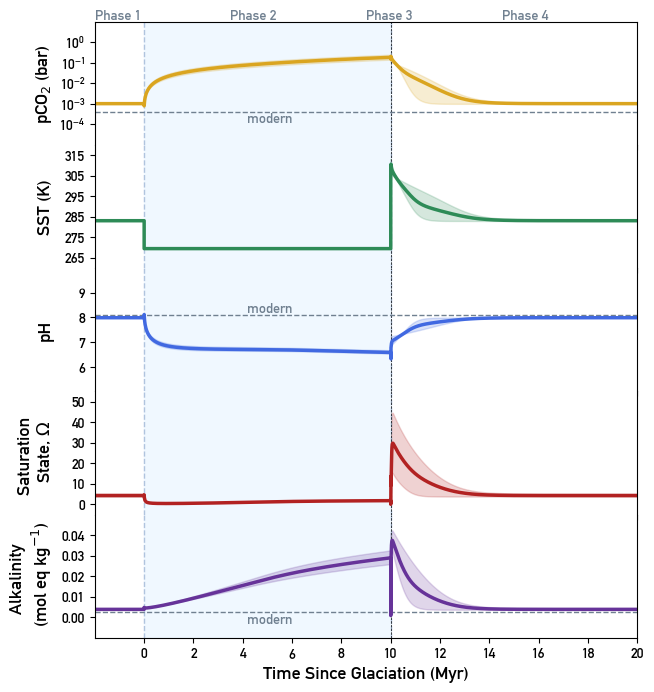

In [12]:
pu.plotFullClimEvol_multi(goose_rec)

### Plot 2: Global climate evolution during the stratified ocean phase

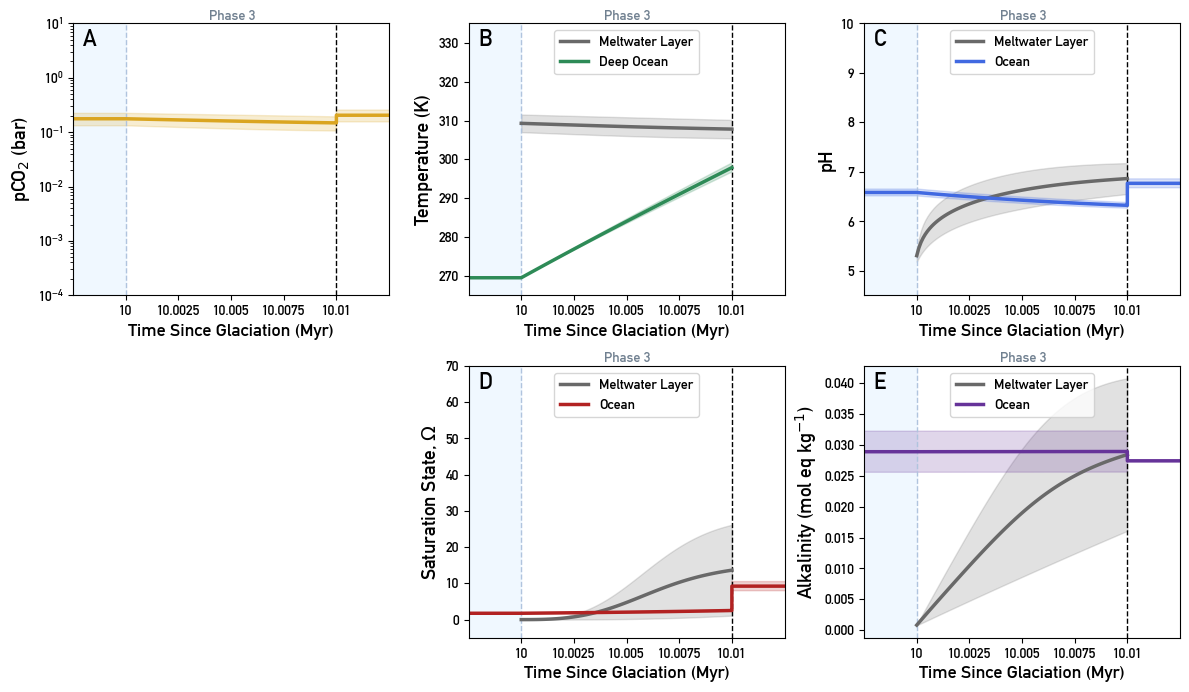

In [13]:
pu.plotStratClimEvol_multi(goose_rec)

### Plot 3: Post-glacial carbonate deposition - mass

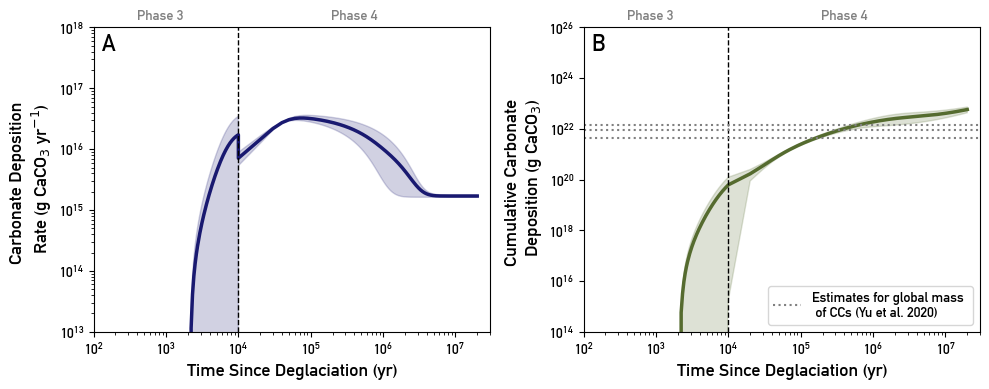

In [14]:
pu.plotPostGlacialCarbMass_multi(goose_rec)

### Plot 4: Post-glacial carbonate deposition - height

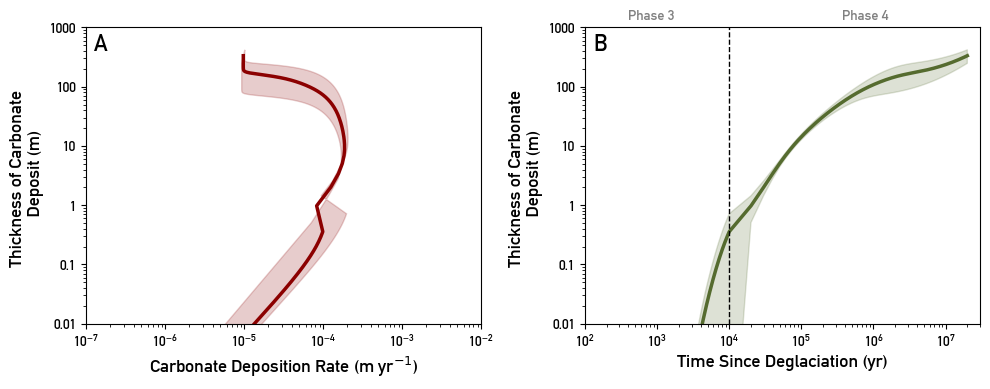

In [15]:
pu.plotPostGlacialCarbHeight_multi(goose_rec)

### Plot 5: Fluxes - median values

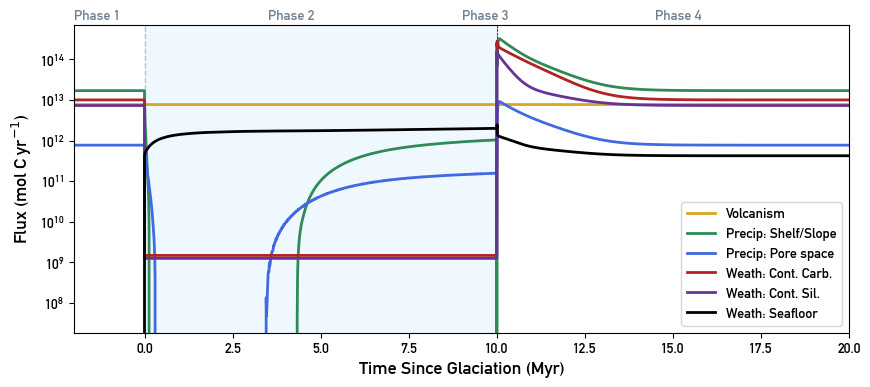

In [16]:
pu.plotFluxes_multi(goose_rec)